<a href="https://colab.research.google.com/github/DaphneXu/some_practice/blob/master/BERT_Word_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this post, I take an in-depth look at word embeddings produced by Google's BERT and show you how to get started with BERT by producing your own word embeddings.

This post is presented in two forms--as a blog post [here](http://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/) and as a Colab notebook [here](https://colab.research.google.com/drive/1ZQvuAVwA3IjybezQOXnrXMGAnMyZRuPU). 
The content is identical in both, but: 

* The blog post format may be easier to read, and includes a comments section for discussion. 
* The Colab Notebook will allow you to run the code and inspect it as you read through.


# Introduction



### History

2018 was a breakthrough year in NLP. Transfer learning, particularly models like Allen AI's ELMO, OpenAI's Open-GPT, and Google's BERT allowed researchers to smash multiple benchmarks with minimal task-specific fine-tuning and provided the rest of the NLP community with pretrained models that could easily (with less data and less compute time) be fine-tuned and implemented to produce state of the art results. Unfortunately, for many starting out in NLP and even for some experienced practicioners, the theory and practical application of these powerful models is still not well understood.

### What is BERT?

BERT (Bidirectional Encoder Representations from Transformers), released in late 2018, is the model we will use in this tutorial to provide readers with a better understanding of and practical guidance for using transfer learning models in NLP. BERT is a method of pretraining language representations that was used to create models that NLP practicioners can then download and use for free. You can either use these models to extract high quality language features from your text data, or you can fine-tune these models on a specific task (classification, entity recognition, question answering, etc.) with your own data to produce state of the art predictions.

### Why BERT embeddings?

In this tutorial, we will use BERT to extract features, namely word and sentence embedding vectors, from text data. What can we do with these word and sentence embedding vectors? First, these embeddings are useful for keyword/search expansion, semantic search and information retrieval. For example, if you want to match customer questions or searches against already answered questions or well documented searches, these representations will help you accuratley retrieve results matching the customer's intent and contextual meaning, even if there's no keyword  or phrase overlap.

Second, and perhaps more importantly, these vectors are used as high-quality feature inputs to downstream models. NLP models such as LSTMs or CNNs require inputs in the form of numerical vectors, and this typically means translating features like the vocabulary and parts of speech into numerical representations. In the past, words have been represented either as uniquely indexed values (one-hot encoding), or more helpfully as neural word embeddings where vocabulary words are matched against the fixed-length feature embeddings that result from models like Word2Vec or Fasttext. BERT offers an advantage over models like Word2Vec, because while each word has a fixed representation under Word2Vec regardless of the context within which the word appears, BERT produces word representations that are dynamically informed by the words around them. For example, given two sentences:

"The man was accused of robbing a bank."
"The man went fishing by the bank of the river."

Word2Vec would produce the same word embedding for the word "bank" in both sentences, while under BERT the word embedding for "bank" would be different for each sentence. Aside from capturing obvious differences like polysemy, the context-informed word embeddings capture other forms of information that result in more accurate feature representations, which in turn results in better model performance.

From an educational standpoint, a close examination of BERT word embeddings is a good way to get  your feet wet with BERT and its family of transfer learning models, and sets us up with some practical knowledge and context to better understand the inner details of the model in later tutorials.

Onward!

### Install and Import

Install the pytorch interface for BERT by Hugging Face. (This library contains interfaces for other pretrained language models like OpenAI's GPT and GPT-2.) We've selected the pytorch interface because it strikes a nice balance between the high-level APIs (which are easy to use but don't provide insight into how things work) and tensorflow code (which contains lots of details but often sidetracks us into lessons about tensorflow, when the purpose here is BERT!).

If you're running this code on Google Colab, you will have to install this library each time you reconnect; the following cell will take care of that for you.

In [1]:
!pip install pytorch-pretrained-bert

     |████████████████████████████████| 133kB 2.7MB/s 
     |████████████████████████████████| 655kB 41.0MB/s 
  Stored in directory: /root/.cache/pip/wheels/35/e4/80/abf3b33ba89cf65cd262af8a22a5a999cc28fbfabea6b38473
Successfully built regex


Now let's import pytorch, the pretrained BERT model, and a BERT tokenizer. We'll explain the BERT model in detail in a later tutorial, but this is the pre-trained model released by Google that ran for many, many hours on Wikipedia and [Book Corpus](https://arxiv.org/pdf/1506.06724.pdf), a dataset containing +10,000 books of different genres. This model is responsible (with a little modification) for beating NLP benchmarks across a range of tasks. Google released a few variations of BERT models, but the one we'll use here is the smaller of the two available sizes ("base" and "large") and ignores casing, hence "uncased.""

In [2]:
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
% matplotlib inline

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


100%|██████████| 231508/231508 [00:00<00:00, 417303.22B/s]


## Input Formatting
Because BERT is a pretrained model that expects input data in a specific format, we will need:

- special tokens to mark the beginning ([CLS]) and separation/end of sentences ([SEP])
- tokens that conforms with the fixed vocabulary used in BERT
- token IDs from BERT's tokenizer
- mask IDs to indicate which elements in the sequence are tokens and which are padding elements
- segment IDs used to distinguish different sentences
- positional embeddings used to show token position within the sequence

Luckily, this interface takes care of some of these input specifications for us so we will only have to manually create a few of them (we'll revisit the other inputs in another tutorial).




###Special Tokens
BERT can take as input either one or two sentences, and expects special tokens to mark the beginning and end of each one:

**2 Sentence Input**:

[CLS] the man went to the store [SEP] he bought a gallon of milk [SEP]

**1 Sentence Input**:

[CLS] the man went to the store [SEP]

In [3]:
text = "Here is the sentence I want embeddings for."
text = "After stealing money from the bank vault, the bank robber was seen fishing on the Mississippi river bank."
marked_text = "[CLS] " + text + " [SEP]"

print (marked_text)

[CLS] After stealing money from the bank vault, the bank robber was seen fishing on the Mississippi river bank. [SEP]


We've imported a BERT-specific tokenizer, let's take a look at the output:

###Tokenization

In [4]:
tokenized_text = tokenizer.tokenize(marked_text)
print (tokenized_text)

['[CLS]', 'after', 'stealing', 'money', 'from', 'the', 'bank', 'vault', ',', 'the', 'bank', 'robber', 'was', 'seen', 'fishing', 'on', 'the', 'mississippi', 'river', 'bank', '.', '[SEP]']


In [11]:
sen = 'embeddings vector'
tokenizer.tokenize('padding')

['pad', '##ding']

Notice how the word "embeddings" is represented:

['em', '##bed', '##ding', '##s']

The original word has been split into smaller subwords and characters. The two hash signs preceding some of these subwords are just our tokenizer's way to denote that this subword or character is part of a larger word and preceded by another subword. So, for example, the '##bed' token is separate from the 'bed' token; the first is used whenever the subword 'bed' occurs within a larger word and the second is used explicitly for when the standalone token 'thing you sleep on' occurs.

Why does it look this way? This is because the BERT tokenizer was created with a WordPiece model. This model greedily creates a fixed-size vocabulary of individual characters, subwords, and words that best fits our language data. Since the vocabulary limit size of our BERT tokenizer model is 30,000, the WordPiece model generated a vocabulary that contains all English characters plus the ~30,000 most common words and subwords found in the English language corpus the model is trained on. This vocabulary contains four things:

1. Whole words
2. Subwords occuring at the front of a word or in isolation ("em" as in "embeddings" is assigned the same vector as the standalone sequence of characters "em" as in "go get em" )
3. Subwords not at the front of a word, which are preceded by '##' to denote this case
4. Individual characters

To tokenize a word under this model, the tokenizer first checks if the whole word is in the vocabulary. If not, it tries to break the word into the largest possible subwords contained in the vocabulary, and as a last resort will decompose the word into individual characters. Note that because of this, we can always represent a word as, at the very least, the collection of its individual characters.

As a result, rather than assigning out of vocabulary words to a catch-all token like 'OOV' or 'UNK,' words that are not in the vocabulary are decomposed into subword and character tokens that we can then generate embeddings for. 

So, rather than assigning "embeddings" and every other out of vocabulary word to an overloaded unknown vocabulary token, we split it into subword tokens ['em', '##bed', '##ding', '##s'] that will retain some of the contextual meaning of the original word.  We can even average these subword embedding vectors to generate an approximate vector for the original word.


(For more information about WordPiece, see the [original paper](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/37842.pdf) and further disucssion in Google's [Neural Machine Translation System](https://arxiv.org/pdf/1609.08144.pdf).)



Here are some examples of the tokens contained in our vocabulary. Tokens beginning with two hashes are subwords or individual characters.

In [5]:
list(tokenizer.vocab.keys())[5000:5020]

['knight',
 'lap',
 'survey',
 'ma',
 '##ow',
 'noise',
 'billy',
 '##ium',
 'shooting',
 'guide',
 'bedroom',
 'priest',
 'resistance',
 'motor',
 'homes',
 'sounded',
 'giant',
 '##mer',
 '150',
 'scenes']

Next, we need to call the tokenizer  to match the tokens agains their indices in the tokenizer vocabulary:

In [6]:
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

for tup in zip(tokenized_text, indexed_tokens):
  print (tup)

('[CLS]', 101)
('after', 2044)
('stealing', 11065)
('money', 2769)
('from', 2013)
('the', 1996)
('bank', 2924)
('vault', 11632)
(',', 1010)
('the', 1996)
('bank', 2924)
('robber', 27307)
('was', 2001)
('seen', 2464)
('fishing', 5645)
('on', 2006)
('the', 1996)
('mississippi', 5900)
('river', 2314)
('bank', 2924)
('.', 1012)
('[SEP]', 102)


In [14]:
indexed_tokens

[101,
 2044,
 11065,
 2769,
 2013,
 1996,
 2924,
 11632,
 1010,
 1996,
 2924,
 27307,
 2001,
 2464,
 5645,
 2006,
 1996,
 5900,
 2314,
 2924,
 1012,
 102]

###Segment ID
BERT is trained on and expects sentence pairs, using 1s and 0s to distinguish between the two sentences. That is, for each token in "tokenized_text," we must specify which sentence it belongs to: sentence 0 (a series of 0s) or sentence 1 (a series of 1s). For our purposes, single-sentence inputs only require a series of 1s, so we will create a vector of 1s for each token in our input sentence. 

If you want to process two sentences, assign each word in the first sentence plus the '[SEP]' token a 0, and all tokens of the second sentence a 1.

In [12]:
segments_ids = [1] * len(tokenized_text)
print (segments_ids)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


##Running our Example
Next we need to convert our data to torch tensors and call the BERT model. The BERT PyTorch interface requires that the data be in torch tensors rather than Python lists, so we convert the lists here - this does not change the shape or the data.
 
model.eval() puts our model in evaluation mode as opposed to training mode. In this case, evaluation mode turns off dropout regularization which is used in training.

Calling `from_pretrained` will fetch the model from the internet. When we load the `bert-base-uncased`, we see the definition of the model printed in the logging. The model is a deep neural network with 12 layers! Explaining the layers and their functions is outside the scope of this post, and you can skip over this output for now.

In [15]:
tokens_tensor

tensor([[  101,  2044, 11065,  2769,  2013,  1996,  2924, 11632,  1010,  1996,
          2924, 27307,  2001,  2464,  5645,  2006,  1996,  5900,  2314,  2924,
          1012,   102]])

In [16]:
segments_tensors

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [13]:

# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased')

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()


100%|██████████| 407873900/407873900 [00:32<00:00, 12530427.99B/s]


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): BertLayerNorm()
    (dropout): Dropout(p=0.1)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): BertLayerNorm()
            (dropout): Dropout(p=0.1)
          )
        )
        (intermediate): BertIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=

Next, let's fetch the hidden states of the network.

torch.no_grad deactivates the gradient calculations, saves memory, and speeds up computation (we don't need gradients or backpropagation since we're just running a forward pass). 


In [0]:
# Predict hidden states features for each layer
with torch.no_grad():
    encoded_layers, _ = model(tokens_tensor, segments_tensors)

## Output
The full set of hidden states for this model, stored in the object `encoded_layers`, is a little dizzying. This object has four dimensions, in the following order:

1. The layer number (12 layers)
2. The batch number (1 sentence)
3. The word / token number (22 tokens in our sentence)
4. The hidden unit / feature number (768 features)

That’s 202,752 unique values just to represent our one sentence!

The second dimension, the batch size, is used when submitting multiple sentences to the model at once; here, though, we just have one example sentence.

In [20]:
print ("Number of layers:", len(encoded_layers))
layer_i = 0

print ("Number of batches:", len(encoded_layers[layer_i]))
batch_i = 0

print ("Number of tokens:", len(encoded_layers[layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(encoded_layers[layer_i][batch_i][token_i]))

Number of layers: 12
Number of batches: 1
Number of tokens: 22
Number of hidden units: 768


Let's take a quick look at the range of values for a given layer and token.

You'll find that the range is fairly similar for all layers and tokens, with the majority of values falling between \[-2, 2\], and a small smattering of values around -10.

In [25]:
len(vec)

768

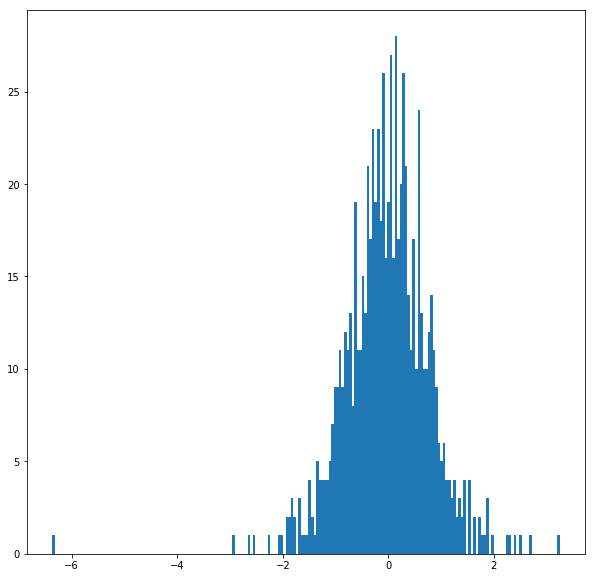

In [23]:
# For the 5th token in our sentence, select its feature values from layer 5.
token_i = 6
layer_i = 5
vec = encoded_layers[layer_i][batch_i][token_i]

# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(10,10))
plt.hist(vec, bins=200)
plt.show()

Grouping the values by layer makes sense for the model, but for our purposes we want it grouped by token. 

The following code just reshapes the values so that we have them in the form: 

```
    [# tokens, # layers, # features]
```

In [26]:
# Convert the hidden state embeddings into single token vectors

# Holds the list of 12 layer embeddings for each token
# Will have the shape: [# tokens, # layers, # features]
token_embeddings = [] 

# For each token in the sentence...
for token_i in range(len(tokenized_text)):
  
  # Holds 12 layers of hidden states for each token 
  hidden_layers = [] 
  
  # For each of the 12 layers...
  for layer_i in range(len(encoded_layers)):
    
    # Lookup the vector for `token_i` in `layer_i`
    vec = encoded_layers[layer_i][batch_i][token_i]
    
    hidden_layers.append(vec)
    
  token_embeddings.append(hidden_layers)

# Sanity check the dimensions:
print ("Number of tokens in sequence:", len(token_embeddings))
print ("Number of layers per token:", len(token_embeddings[0]))

Number of tokens in sequence: 22
Number of layers per token: 12


In [0]:
token_embeddings[2]

## Creating word and sentence vectors from hidden states

Now, what do we do with these hidden states? We would like to get individual vectors for each of our tokens, or perhaps a single vector representation of the whole sentence, but for each token of our input we have 12 separate vectors each of length 768.

In order to get the individual vectors we will need to combine some of the layer vectors...but which layer or combination of layers provides the best representation? The BERT authors tested this by feeding different vector combinations as input features to a BiLSTM used on a named entity recognition task and observing the resulting F1 scores.

(Image from [Jay Allamar](http://jalammar.github.io/illustrated-bert/)'s blog)


![alt text](http://jalammar.github.io/images/bert-feature-extraction-contextualized-embeddings.png)

While concatenation of the last four layers produced the best results on this specific task, many of the other methods come in a close second and in general it is advisable to test different versions for your specific application: results may vary.

This is partially demonstrated by noting that the different layers of BERT encode very different kinds of information, so the appropriate pooling strategy will change depending on the application because different layers encode different kinds of information. Hanxiao's discussion of this topic is relevant, as are their experiments looking at the PCA visualizations of different layers trained on a news dataset and observing the differences in the four class separations from different pooling strategies:

(Images from [Hanxiao's](https://github.com/hanxiao/bert-as-service) BERT-as-a-service)

![alt text](https://raw.githubusercontent.com/hanxiao/bert-as-service/master/.github/pool_mean.png)
![alt text](https://raw.githubusercontent.com/hanxiao/bert-as-service/master/.github/pool_max.png)

The upshot being that, again**, the correct pooling strategy (mean, max, concatenation, etc.) and layers used (last four, all, last layer, etc.) is dependent on the application**. This discussion of pooling strategies applies both to entire sentence embeddings and individual ELMO-like token embeddings.







### Word Vectors

To give you some examples, let's create word vectors two ways. 

First, let's **concatenate** the last four layers, giving us a single word vector per token. Each vector will have length `4 x 768 = 3,072`. 

In [29]:
# Stores the token vectors, with shape [22 x 3,072]
token_vecs_cat = []

# For each token in the sentence...
for token in token_embeddings:
    # Concatenate the vectors (that is, append them together) from the last 
    # four layers.
    # Each layer vector is 768 values, so `cat_vec` is length 3,072.
    cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), 0)
    
    # Use `cat_vec` to represent `token`.
    token_vecs_cat.append(cat_vec)

print ('Shape is: %d x %d' % (len(token_vecs_cat), len(token_vecs_cat[0])))

Shape is: 22 x 3072


As an alternative method, let's try creating the word vectors by **summing** together the last four layers.

In [31]:
# Stores the token vectors, with shape [22 x 768]
token_vecs_sum = []

# For each token in the sentence...
for token in token_embeddings:
    # Sum the vectors from the last four layers.
    sum_vec = torch.sum(torch.stack(token)[-4:], 0)
    
    # Use `sum_vec` to represent `token`.
    token_vecs_sum.append(sum_vec)

print ('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))

Shape is: 22 x 768


### Sentence Vectors

To get a single vector for our entire sentence we have multiple application-dependent strategieis, but a simple approach is to average the second to last hiden layer of each token producing a single 768 length vector.



In [37]:
encoded_layers[11].shape

torch.Size([1, 22, 768])

In [0]:
sentence_embedding = torch.mean(encoded_layers[11], 1)

In [39]:
sentence_embedding

tensor([[ 3.2873e-02, -2.3461e-01, -7.9924e-02,  3.8905e-01,  8.8793e-01,
          2.1375e-01, -7.8063e-03,  6.2694e-01, -3.2631e-02, -3.4703e-01,
          1.2331e-01, -9.4772e-02, -7.4420e-02,  4.5523e-01, -4.7217e-01,
          1.0344e-01,  3.4667e-01,  1.0410e-01,  5.4372e-01,  6.9113e-02,
         -8.2880e-02,  6.7866e-02,  1.2871e-01,  2.3312e-01,  4.2933e-01,
         -1.2449e-02, -2.1360e-01,  2.2697e-01, -1.2763e-01,  2.8080e-01,
          5.4766e-01, -1.0080e-01,  7.5650e-02, -2.7152e-01, -1.4124e-01,
         -4.0931e-01, -1.9237e-01, -3.9813e-02, -2.3175e-01,  3.3040e-01,
         -3.8484e-01, -3.7469e-01, -2.4978e-01,  3.2707e-01, -9.0552e-04,
         -4.4285e-01,  7.6833e-02, -4.4618e-02,  1.9808e-02,  7.4679e-02,
         -3.2986e-01,  8.2114e-01, -7.6256e-01, -4.1610e-04,  8.9090e-02,
          5.3472e-01, -3.8244e-01, -6.0184e-01, -8.3941e-02, -9.6009e-02,
          3.7689e-01, -2.5287e-01,  4.6429e-01, -5.4761e-01, -2.1230e-02,
          2.0828e-02,  4.8191e-01,  2.

In [33]:
print ("Our final sentence embedding vector of shape:"), sentence_embedding[0].shape[0]

Our final sentence embedding vector of shape:


(None, 768)

### Confirming contextually dependent vectors

To confirm that the value of these vectors are in fact contextually dependent, let's take a look at the output from the following sentence (if you want to try this out you'll have to run this example separately from the top by replacing our original sentence with the following sentence):

In [41]:
print (text)

After stealing money from the bank vault, the bank robber was seen fishing on the Mississippi river bank.


In [42]:
for i,x in enumerate(tokenized_text):
  print (i,x)

0 [CLS]
1 after
2 stealing
3 money
4 from
5 the
6 bank
7 vault
8 ,
9 the
10 bank
11 robber
12 was
13 seen
14 fishing
15 on
16 the
17 mississippi
18 river
19 bank
20 .
21 [SEP]


In [43]:
print ("First fifteen values of 'bank' as in 'bank robber':")
token_vecs_sum[10][:15]

First fifteen values of 'bank' as in 'bank robber':


tensor([ 1.1868, -1.5298, -1.3770,  1.0648,  3.1446,  1.4003, -4.2407,  1.3946,
        -0.1170, -1.8777,  0.1091, -0.3862,  0.6744,  2.1924, -4.5306])

In [44]:
print ("First fifteen values of 'bank' as in 'bank vault':")
token_vecs_sum[6][:15]

First fifteen values of 'bank' as in 'bank vault':


tensor([ 2.1319, -2.1413, -1.6260,  0.8638,  3.3173,  0.1796, -4.4853,  3.1215,
        -0.9740, -3.1780,  0.1046, -1.5481,  0.4758,  1.1703, -4.4859])

In [45]:
print ("First fifteen values of 'bank' as in 'river bank':")
token_vecs_sum[19][:15]

First fifteen values of 'bank' as in 'river bank':


tensor([ 1.1295, -1.4725, -0.7296, -0.0901,  2.4970,  0.5330,  0.9742,  5.1834,
        -1.0692, -1.5941,  1.9261,  0.7119, -0.9809,  1.2127, -2.9812])

As we can see, these are all different vectors and they should be; although the word 'bank' is the same, in each case of our sentence it has different meanings, sometimes very different meanings.

We have three different uses of "bank" in this sentence, two of which should be almost identical. Let's check the cosine similarity to see if this is the case:

In [0]:
from sklearn.metrics.pairwise import cosine_similarity

# Compare "bank" as in "bank robber" to "bank" as in "river bank"
different_bank = cosine_similarity(token_vecs_sum[10].reshape(1,-1), token_vecs_sum[19].reshape(1,-1))[0][0]

# Compare "bank" as in "bank robber" to "bank" as in "bank vault" 
same_bank = cosine_similarity(token_vecs_sum[10].reshape(1,-1), token_vecs_sum[6].reshape(1,-1))[0][0]

In [47]:
print ("Similarity of 'bank' as in 'bank robber' to 'bank' as in 'bank vault':",  same_bank)

Similarity of 'bank' as in 'bank robber' to 'bank' as in 'bank vault': 0.94567525


In [48]:
print ("Similarity of 'bank' as in 'bank robber' to 'bank' as in 'river bank':",  different_bank)

Similarity of 'bank' as in 'bank robber' to 'bank' as in 'river bank': 0.6797334


## Other: special tokens, OOV words, and similarity metrics

### Special tokens

It should be noted that although the** "[CLS]"** acts as an "aggregate representation" for classification tasks, this is not the best choice for a high quality sentence embedding vector. [According to](https://github.com/google-research/bert/issues/164) BERT author Jacob Devlin: "*I'm not sure what these vectors are, since BERT does not generate meaningful sentence vectors. It seems that this is is doing average pooling over the word tokens to get a sentence vector, but we never suggested that this will generate meaningful sentence representations*."

(However, the [CLS] token does become meaningful if the model has been fine-tuned, where the last hidden layer of this token is used as the "sentence vector" for sequence classification.)

### Out of vocabulary words

For** out of vocabulary words** that are composed of multiple sentence and character-level embeddings, there is a further issue of how best to recover this embedding. Averaging the embeddings is the most straightforward solution (one that is relied upon in similar embedding models with subword vocabularies like fasttext), but summation of subword embeddings and simply taking the last token embedding (remember that the vectors are context sensitive) are acceptable alternative strategies.

### Similarity metrics

It is worth noting that word-level **similarity comparisons** are not appropriate with BERT embeddings because these embeddings are contextually dependent, meaning that the word vector changes depending on the sentence it appears in. This allows wonderful things like polysemy so that e.g. your representation encodes river "bank" and not a financial institution "bank",  but makes direct word-to-word similarity comparisons less valuable. However, for sentence embeddings similarity comparison is still valid such that one can query, for example, a single sentence against a dataset of other sentences in order to find the most similar. Depending on the similarity metric used, the resulting similarity values will be less informative than the relative ranking of similarity outputs since many similarity metrics make assumptions about the vector space (equally-weighted dimensions, for example) that do not hold for our 768-dimensional vector space.


## Implementations

You can use the code in this notebook as the foundation of your own application to extract BERT features from text. However, official [tensorflow](https://github.com/google-research/bert/blob/master/extract_features.py) and well-regarded [pytorch](https://github.com/huggingface/pytorch-pretrained-BERT/blob/master/examples/extract_features.py) implementations already exist that do this for you.  Additionally, [bert-as-a-service](https://github.com/hanxiao/bert-as-service) is an excellent tool designed specifically for running this task with high performance, and is the one I would recommend for production applications. The author has taken great care in the tool's implementation and provides excellent documentation (some of which was used to help create this tutorial) to help users understand the more nuanced details the user faces, like resource management and pooling strategy.